In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import kagglehub
from typing import Dict, List, Tuple

In [26]:
dataset_path = kagglehub.dataset_download("parsasam/captcha-dataset")
dataset_path = Path(dataset_path)

# !git clone https://github.com/gprudhomme/ML-TermProject-Captcha.git
# dataset_path = "./ML-TermProject-Captcha/preprocessed"

In [27]:
CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
NUM_CLASSES: int = len(CHARACTERS)
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
INDEX_TO_CHAR = {idx: char for char, idx in CHAR_TO_INDEX.items()}
CAPTCHA_LENGTH: int = 5  # Captchas are exactly 5 characters long

def encode_label(label: str) -> torch.Tensor:
    assert len(label) == 5, "Label must be exactly 5 characters long."
    indices = [CHAR_TO_INDEX[char] for char in label]
    one_hot = torch.zeros(len(label), NUM_CLASSES)
    for i, index in enumerate(indices):
        one_hot[i][index] = 1
    return one_hot

def decode_label(one_hot: torch.Tensor) -> str:
    decoded_chars = []
    for i in range(one_hot.size(0)):
        index = torch.argmax(one_hot[i]).item()
        decoded_chars.append(INDEX_TO_CHAR[index])
    return ''.join(decoded_chars)

# Test encoding and decoding
label = "A1bCd"
encoded_label = encode_label(label)
print("Encoded Label:\n", encoded_label)

decoded_label = decode_label(encoded_label)
print("Decoded Label:", decoded_label)


Encoded Label:
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [28]:
from collections import Counter
import cv2

# Image processing
def process(image):
    # 1st part
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    common = []
    RANGE=25
    for i in range(RANGE):
      common.append(Counter(image.flatten()).most_common(RANGE+1)[i][0])


    temp = image.copy()
    for i, row in enumerate(temp):
      for j, pixel in enumerate(row):
        if pixel in common:
          # temp[i][j] = 0   # keep
          pass
        else:
          temp[i][j] = 255 # discard


    ret,temp = cv2.threshold(temp, 0, 255, cv2.THRESH_OTSU)

    # limit if too much or too little is filtered out
    if Counter(temp.flatten()).most_common(2)[1][1] < 500 or Counter(temp.flatten()).most_common(2)[1][1] > 1000:
      ret,image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    else:
      image = temp


    # 2nd part
    if image[0][0] == 0:
      image = cv2.bitwise_not(image)

    # all non-white pixels are now black
    for i, row in enumerate(image):
      for j, pixel in enumerate(row):
        if pixel != 255:
          image[i][j] = 0


    # FIXME TODO Try removing GaussianBlur and Dilate when training
    image = cv2.GaussianBlur(image, (7,7), 0)

    # Creating kernel
    kernel = np.ones((2, 2), np.uint8)

    image = cv2.dilate(image, kernel, cv2.BORDER_REFLECT)

    return image

In [29]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor()
])

class CaptchaDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]  # Assuming .jpg files
        self.num_chars = 5  # Fixed length of label (5 characters)

    def __len__(self):
        return len(self.image_files)

    def encode_label(self, label: str) -> torch.Tensor:
        """Encodes a 5-character label into a one-hot tensor."""
        assert len(label) == self.num_chars, "Label must be exactly 5 characters long."
        indices = [CHAR_TO_INDEX[char] for char in label]
        one_hot = torch.zeros(self.num_chars, NUM_CLASSES)
        for i, index in enumerate(indices):
            one_hot[i][index] = 1
        return one_hot

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = img_name.split('.')[0]  # Extract label from filename (without the .jpg extension)
        img_path = os.path.join(self.img_dir, img_name)

        # Open the image and apply the transform (if any)
        # image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(img_path)

        # image = process(image)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label_one_hot = self.encode_label(label)

        return image, label_one_hot

In [30]:
# Create the dataset and dataloaders
dataset = CaptchaDataset(img_dir=dataset_path, transform=transform)

train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split the dataset into training and testing sets
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
class CaptchaCNN(nn.Module):
    def __init__(self):
        super(CaptchaCNN, self).__init__()

        # Define the individual convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        # self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)    # 1 for black and white
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, kernel_size=2, padding=1)

        # Define the MaxPool layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dummy input to calculate the output size after convolutions
        self.dummy_input = torch.zeros(1, 3, 40, 150)  # Example input size: (batch_size, channels, height, width)
        # self.dummy_input = torch.zeros(1, 1, 40, 150)  # Example input size: (batch_size, channels, height, width)
        conv_output = self._forward_conv(self.dummy_input)  # Get output shape after convolution
        conv_output_size = conv_output.view(1, -1).size(1)  # Flatten the output and get size

        # Define fully connected layers
        # self.fc1 = nn.Linear(conv_output_size, 256)
        # self.fc2 = nn.Linear(256, CAPTCHA_LENGTH * NUM_CLASSES)
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, CAPTCHA_LENGTH * NUM_CLASSES)

    def _forward_conv(self, x):
        # Pass through the convolutional layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool4(x)

        return x

    def forward(self, x):
        # Pass through convolution layers
        x = self._forward_conv(x)

        # Flatten the output of the convolutional layers
        x = x.flatten(start_dim=1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Reshape to match the desired output format
        return x.view(-1, CAPTCHA_LENGTH, NUM_CLASSES)

In [32]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
def load_checkpoint(model, optimizer, checkpoints_dir="checkpoints"):
    # List all checkpoint files in the directory
    checkpoint_files = [f for f in os.listdir(checkpoints_dir) if f.endswith(".pth")]

    # If no checkpoint exists, return the model and optimizer state without modification
    if not checkpoint_files:
        print("No checkpoint found, starting fresh.")
        return model, optimizer, 0, []

    # Find the most recent checkpoint (by sorting the files)
    latest_checkpoint = max(checkpoint_files, key=lambda f: int(f.split('_')[2].split('.')[0]))  # Sorting by epoch number
    checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint)

    # Load checkpoint data
    checkpoint = torch.load(checkpoint_path)

    # Restore model state, optimizer state, and other checkpoint data
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the starting epoch and loss history
    starting_epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']

    print(f"Loaded checkpoint from epoch {starting_epoch}")

    return model, optimizer, starting_epoch, loss_history


In [38]:
model, optimizer, start_epoch, loss_history = load_checkpoint(model, optimizer)

print(f"Loss history length: {len(loss_history)}")

Loaded checkpoint from epoch 22
Loss history length: 70653


In [35]:
def train_model(model, train_loader, optimizer, criterion, epochs=10,
                print_every=100, checkpoints_dir="checkpoints", starting_epoch=0, loss_history=None):
    if loss_history is None:
        loss_history = []  # Initialize loss history if not provided

    total_batches = len(train_loader)  # Total number of batches per epoch

    # Ensure the checkpoints directory exists
    os.makedirs(checkpoints_dir, exist_ok=True)

    model.train()
    for epoch in range(starting_epoch, epochs):  # Start from the checkpoint's epoch
        total_loss = 0
        start_epoch_time = time.time()  # Record start time of the epoch

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # if loss.item() < 0.007:
            #     checkpoint_filename = f"model_epoch_{epoch}_good_loss_{loss.item()}.pth"
            #     checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename)

            #     torch.save({
            #         'epoch': epoch,
            #         'model_state_dict': model.state_dict(),
            #         'optimizer_state_dict': optimizer.state_dict(),
            #         'loss_history': loss_history,
            #     }, checkpoint_path)
            #     print(f"Saved model checkpoint with good loss to {checkpoint_filename}")

            if loss.item() < 0.001:
                checkpoint_filename = f"model_epoch_{epoch}_SUPER_loss_{loss.item()}.pth"
                checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename)

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_history': loss_history,
                }, checkpoint_path)
                print(f"Saved model checkpoint with SUPER loss to {checkpoint_filename}")


            # Calculate total elapsed time since the start of training
            total_elapsed_time = time.time() - start_epoch_time
            avg_batch_time = total_elapsed_time / (batch_idx + 1)

            # Print loss and total elapsed time at specified frequency
            if batch_idx % print_every == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item():.4f}, "
                      f"Total Elapsed Time: {total_elapsed_time:.2f}s, Avg Time per Batch: {avg_batch_time:.4f}s")

            loss_history.append(loss.item())

        # Save checkpoint at the end of the epoch
        checkpoint_filename = f"model_epoch_{epoch+1}.pth"
        checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename)

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
        }, checkpoint_path)
        print(f"Saved model checkpoint for epoch [{epoch+1}/{epochs}] to {checkpoint_filename}")

        # Calculate total epoch time and print the information
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - start_epoch_time
        print(f"Epoch {epoch+1}/{epochs}, Epoch Time: {epoch_time:.2f}s")

    return loss_history


In [36]:
history = train_model(
    model=model,
    train_loader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=40,
    print_every=100,
    checkpoints_dir='checkpoints',
    starting_epoch=start_epoch,
    loss_history=loss_history
)

Epoch [35/40], Batch [1/2827], Loss: 0.0101, Total Elapsed Time: 1.82s, Avg Time per Batch: 1.8211s
Epoch [35/40], Batch [101/2827], Loss: 0.0093, Total Elapsed Time: 187.57s, Avg Time per Batch: 1.8572s
Epoch [35/40], Batch [201/2827], Loss: 0.0056, Total Elapsed Time: 373.00s, Avg Time per Batch: 1.8557s
Epoch [35/40], Batch [301/2827], Loss: 0.0122, Total Elapsed Time: 556.83s, Avg Time per Batch: 1.8499s
Epoch [35/40], Batch [401/2827], Loss: 0.0073, Total Elapsed Time: 740.62s, Avg Time per Batch: 1.8469s
Epoch [35/40], Batch [501/2827], Loss: 0.0081, Total Elapsed Time: 925.91s, Avg Time per Batch: 1.8481s
Epoch [35/40], Batch [601/2827], Loss: 0.0088, Total Elapsed Time: 1114.24s, Avg Time per Batch: 1.8540s
Epoch [35/40], Batch [701/2827], Loss: 0.0078, Total Elapsed Time: 1299.82s, Avg Time per Batch: 1.8542s
Epoch [35/40], Batch [801/2827], Loss: 0.0075, Total Elapsed Time: 1486.60s, Avg Time per Batch: 1.8559s
Epoch [35/40], Batch [901/2827], Loss: 0.0054, Total Elapsed Time

KeyboardInterrupt: 

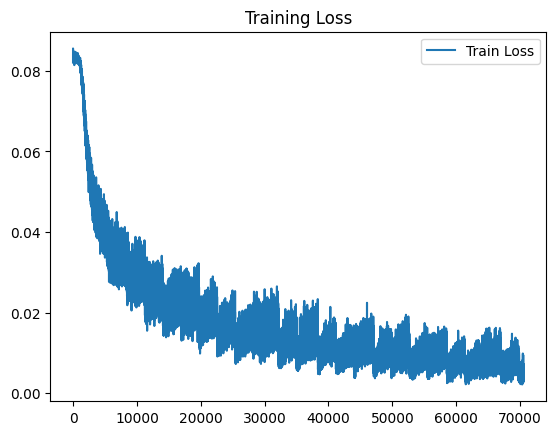

0.004309602547436953


In [39]:
# Function to plot training results
def plot_results(history):
    plt.plot(history, label='Train Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.show()

plot_results(loss_history[50:])

print(loss_history[-1])

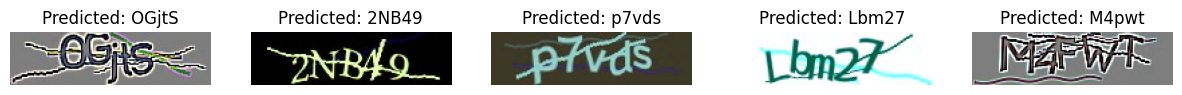

In [40]:
# Function to predict labels from the model
def predict(model, dataloader, device):
    model.eval()
    images, labels = next(iter(dataloader))

    # process step
    images = images.to(device)
    outputs = model(images)
    predicted_labels = []
    for output in outputs:
        predicted_label = decode_label(output)
        predicted_labels.append(predicted_label)
    return images.cpu(), predicted_labels

# Get some images and their predicted labels
images, predicted_labels = predict(model, test_dataloader, device)

# Display a few images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0), cmap='gray')
    ax.set_title(f"Predicted: {predicted_labels[i]}")
    ax.axis('off')
plt.show()

In [42]:
def evaluate_model(model, dataloader, device):
    model.eval()
    results = {
        "total_captchas": 0,
        "correct_captchas": 0,
        "4_correct": 0,
        "3_correct": 0,
        "2_correct": 0,
        "1_correct": 0,
        "5_letter_correct": 0,
        "4_letter_correct": 0,
        "3_letter_correct": 0,
        "2_letter_correct": 0,
        "1_letter_correct": 0,
        "none_correct": 0,
        "total_letters": 0,
        "correct_letters": 0,
    }

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)

            for output, label in zip(outputs, labels):
                predicted_label = decode_label(output)
                real_label = decode_label(label)

                results["total_captchas"] += 1
                results["total_letters"] += CAPTCHA_LENGTH

                correct_count = 0
                for i, letter in enumerate(predicted_label):
                    if letter == real_label[i]:
                        results[f"{i+1}_letter_correct"] += 1
                        correct_count += 1

                if correct_count == 4:
                    results["4_correct"] += 1

                if correct_count == 3:
                    results["3_correct"] += 1

                if correct_count == 2:
                    results["2_correct"] += 1

                if correct_count == 1:
                    results["1_correct"] += 1

                if correct_count == 0:
                    results["none_correct"] += 1

                if predicted_label == real_label:
                    results["correct_captchas"] += 1

                results["correct_letters"] += sum(p == r for p, r in zip(predicted_label, real_label))
        return results

results = evaluate_model(model, test_dataloader, device)

In [44]:
print(f"Correct Captchas: {results['correct_captchas']}/{results['total_captchas']} ({results['correct_captchas']/results['total_captchas']:.2%})")
print(f"4 Correct: {results['4_correct']}/{results['total_captchas']} ({results['4_correct']/results['total_captchas']:.2%})")
print(f"3 Correct: {results['3_correct']}/{results['total_captchas']} ({results['3_correct']/results['total_captchas']:.2%})")
print(f"2 Correct: {results['2_correct']}/{results['total_captchas']} ({results['2_correct']/results['total_captchas']:.2%})")
print(f"1 Correct: {results['1_correct']}/{results['total_captchas']} ({results['1_correct']/results['total_captchas']:.2%})")
print(f"None Correct: {results['none_correct']}/{results['total_captchas']} ({results['none_correct']/results['total_captchas']:.2%})")

print(f"Fifth Correct: {results['5_letter_correct']}/{results['total_captchas']} ({results['5_letter_correct']/results['total_captchas']:.2%})")
print(f"Fourth Correct: {results['4_letter_correct']}/{results['total_captchas']} ({results['4_letter_correct']/results['total_captchas']:.2%})")
print(f"Third Correct: {results['3_letter_correct']}/{results['total_captchas']} ({results['3_letter_correct']/results['total_captchas']:.2%})")
print(f"Second Correct: {results['2_letter_correct']}/{results['total_captchas']} ({results['2_letter_correct']/results['total_captchas']:.2%})")
print(f"First Correct: {results['1_letter_correct']}/{results['total_captchas']} ({results['1_letter_correct']/results['total_captchas']:.2%})")

print(f"Correct Letters: {results['correct_letters']}/{results['total_letters']} ({results['correct_letters']/results['total_letters']:.2%})")

Correct Captchas: 20063/22613 (88.72%)
4 Correct: 2200/22613 (9.73%)
3 Correct: 288/22613 (1.27%)
2 Correct: 54/22613 (0.24%)
1 Correct: 6/22613 (0.03%)
None Correct: 2/22613 (0.01%)
Fifth Correct: 22275/22613 (98.51%)
Fourth Correct: 21887/22613 (96.79%)
Third Correct: 21723/22613 (96.06%)
Second Correct: 21934/22613 (97.00%)
First Correct: 22274/22613 (98.50%)
Correct Letters: 110093/113065 (97.37%)


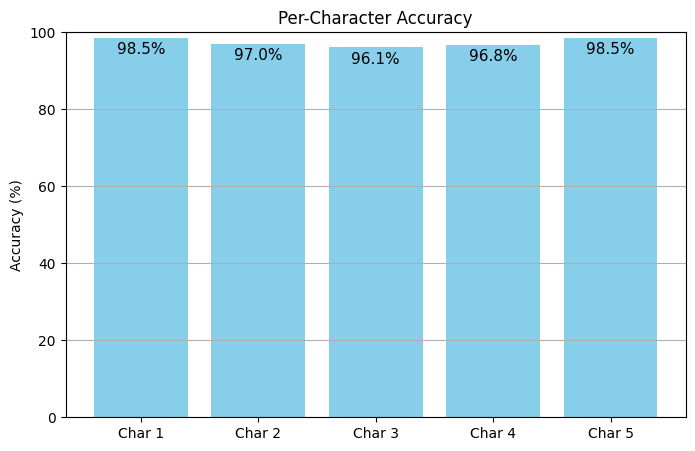

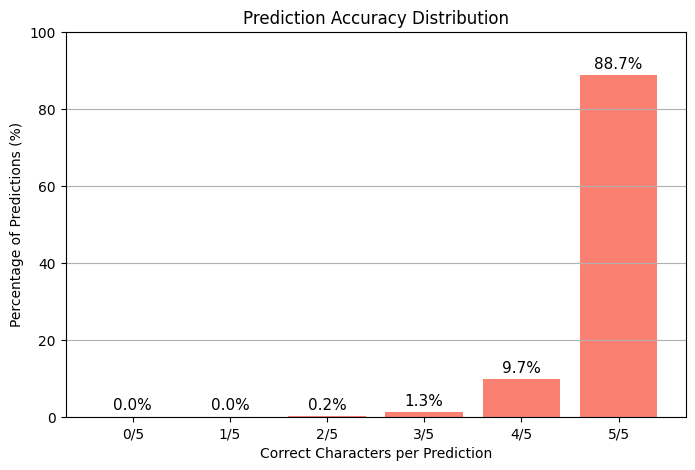

In [78]:
#result_matches = np.array(results['captcha_results'])

# position_accuracy = np.mean(result_matches, axis=0) * 100
fifth_corect = float(f"{(results['5_letter_correct'] / results['total_captchas']) * 100:.2f}")
fourth_correct = float(f"{(results['4_letter_correct'] / results['total_captchas']) * 100:.2f}")
third_corect = float(f"{(results['3_letter_correct'] / results['total_captchas']) * 100:.2f}")
second_correct = float(f"{(results['2_letter_correct'] / results['total_captchas']) * 100:.2f}")
first_correct = float(f"{(results['1_letter_correct'] / results['total_captchas']) * 100:.2f}")

position_accuracy = [
    first_correct,
    second_correct,
    third_corect,
    fourth_correct,
    fifth_corect
]

positions = [f'Char {i+1}' for i in range(5)]
plt.figure(figsize=(8, 5))
bars = plt.bar(positions, position_accuracy, color='skyblue')
plt.ylim(0, 100)
plt.title('Per-Character Accuracy')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 5,
        f'{height:.1f}%',
        ha='center', va='bottom', fontsize=11
    )

plt.show()


correct_captchas = float(f"{(results['correct_captchas']/results['total_captchas']) * 100:.2f}")
four_correct = float(f"{(results['4_correct']/results['total_captchas']) * 100:.2f}")
three_correct = float(f"{(results['3_correct']/results['total_captchas']) * 100:.2f}")
two_correct = float(f"{(results['2_correct']/results['total_captchas']) * 100:.2f}")
one_correct = float(f"{(results['1_correct']/results['total_captchas']) * 100:.2f}")
zero_correct = float(f"{(results['none_correct']/results['total_captchas']) * 100:.2f}")

captcha_accuracy = [
    zero_correct,
    one_correct,
    two_correct,
    three_correct,
    four_correct,
    correct_captchas
]

labels = [f'{i+1}/5' for i in range(-1, 5)]
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, captcha_accuracy, color='salmon')
plt.ylim(0, 100)
plt.title('Prediction Accuracy Distribution')
plt.ylabel('Percentage of Predictions (%)')
plt.xlabel('Correct Characters per Prediction')
plt.grid(axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center', va='bottom', fontsize=11
    )

plt.show()